## Import modules and load data

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
tqdm.pandas()

In [3]:
df_notes = pd.read_csv('../data/original/NOTEEVENTS.csv', low_memory=False)

In [4]:
df_icustays = pd.read_csv('../data/original/ICUSTAYS.csv')

In [5]:
multi_to_patid = pd.read_csv('../data/processed/multi_to_patid.csv')

## Filter & clean table

In [6]:
rel_cats = ['SUBJECT_ID','HADM_ID','CHARTDATE','CHARTTIME','CATEGORY','TEXT']
df_notes = df_notes[rel_cats]
# Why have notes if they have no text
df_notes.dropna(subset=['TEXT'], inplace=True)
# Make it friendly for datetime comparisons later on
df_notes.CHARTDATE = df_notes.CHARTDATE.astype('datetime64[ns]')
df_notes.CHARTTIME = df_notes.CHARTTIME.astype('datetime64[ns]')

Create multi-level index

In [7]:
df_notes.set_index(['SUBJECT_ID','HADM_ID'], inplace=True)

Clean up category names

In [8]:
df_notes.loc[df_notes.CATEGORY == 'Discharge summary', 'CATEGORY'] = 'Discharge'
df_notes.loc[df_notes.CATEGORY == 'Physician ', 'CATEGORY'] = 'Physician'
df_notes.loc[df_notes.CATEGORY == 'Respiratory ', 'CATEGORY'] = 'Respiratory'

Select common categories

In [9]:
relevant_cats = ["Discharge","Nursing/other","Radiology","Nursing","ECG","Physician","Echo","Respiratory","Nutrition","General"]
df_notes = df_notes.loc[df_notes.CATEGORY.map(lambda x: x in relevant_cats)]

## Clean up df_icustays

In [10]:
# Convert from 'object' to 'datetime'
df_icustays.INTIME = df_icustays.INTIME.astype('datetime64[ns]')
df_icustays.OUTTIME = df_icustays.OUTTIME.astype('datetime64[ns]')
# Create date columns in case row in question doesn't have a 'CHARTTIME' for comparison
df_icustays['INDATE'] = df_icustays.INTIME.dt.date.astype('datetime64[ns]')
df_icustays['OUTDATE'] = df_icustays.OUTTIME.dt.date.astype('datetime64[ns]')
# Select only the first ICU stay for a patient across all admissions
df_icustays = df_icustays.sort_values(by='INTIME').groupby(['SUBJECT_ID']).first()
# Select the minimal information needed to match ICU stays to clinical notes
df_icustays = df_icustays[["HADM_ID","ICUSTAY_ID","INTIME","INDATE","OUTTIME","OUTDATE"]]
# Impossible to verify notes belong to an ICU stay without a time
df_icustays.dropna(subset=['INTIME','OUTTIME'], inplace=True)
# Each index is a single patient's first ICU visit (we removed multiple ICU visits)
df_icustays.reset_index(inplace=True)
df_icustays.set_index(['SUBJECT_ID','HADM_ID','ICUSTAY_ID'], inplace=True)

### Limit to first icustay

In [11]:
df_notes_icu = df_icustays.copy()
df_notes_icu = df_notes_icu.join(df_notes, how='inner')

In [12]:
# Date comparison
date_val = (df_notes_icu.CHARTDATE >= df_notes_icu.INDATE) & (df_notes_icu.CHARTDATE <= df_notes_icu.OUTDATE)
# Time comparison
time_val = (df_notes_icu.CHARTTIME >= df_notes_icu.INTIME) & (df_notes_icu.CHARTTIME <= df_notes_icu.OUTTIME)
# Valid?
datetime_val = (df_notes_icu.CHARTTIME.isna() & date_val) | (~df_notes_icu.CHARTTIME.isna() & time_val) 
# Filter rows
df_notes_icu = df_notes_icu.loc[datetime_val]

### Match Cohorts to pre-selected cohort

In [13]:
multi_to_patid.set_index(['subject_id','hadm_id','icustay_id'], inplace=True)
df_notes_icu.index.names = ['subject_id','hadm_id','icustay_id']

In [14]:
df_notes_icu = multi_to_patid.join(df_notes_icu, how='left')

In [15]:
df_notes_icu.dropna(subset=['INTIME','INDATE'], inplace=True)

In [16]:
df_notes_icu.reset_index(inplace=True)
df_notes_icu.set_index('pat_id', inplace=True)
df_notes_icu.drop(['subject_id','hadm_id','icustay_id'], axis=1, inplace=True)

### Split Static from Time series notes

In [214]:
df_notes_static = df_notes_icu.loc[df_notes_icu.CATEGORY == 'Discharge', :].copy()
df_notes_ts = df_notes_icu.loc[~(df_notes_icu.CATEGORY == 'Discharge'), :].copy()

### Trim static notes

In [215]:
df_notes_static["TEXT_LEN"] = df_notes_static.TEXT.map(lambda s: len(s))
df_notes_static = df_notes_static.sort_values(by='TEXT_LEN', ascending=False).groupby('pat_id').first()

In [216]:
df_notes_static = df_notes_static[['TEXT']]

### Handle ECG and Echo

In [217]:
merged_ecg = df_notes_ts.loc[df_notes_ts.CATEGORY == 'ECG'].groupby(['pat_id','CHARTDATE']).TEXT.agg(lambda s: ' [SEP] '.join(s))
merged_echo = df_notes_ts.loc[df_notes_ts.CATEGORY == 'Echo'].groupby(['pat_id','CHARTDATE']).TEXT.agg(lambda s: ' [SEP] '.join(s))

In [218]:
df_ecg = df_notes_ts.loc[df_notes_ts.CATEGORY == 'ECG']
df_ecg = df_ecg.reset_index().groupby(['pat_id','CHARTDATE']).first()
df_ecg.TEXT = merged_ecg.values
df_ecg = df_ecg.reset_index().set_index('pat_id')

In [219]:
df_echo = df_notes_ts.loc[df_notes_ts.CATEGORY == 'Echo']
df_echo = df_echo.reset_index().groupby(['pat_id','CHARTDATE']).first()
df_echo.TEXT = merged_echo.values
df_echo = df_echo.reset_index().set_index('pat_id')

In [220]:
df_dateonly = pd.concat([df_echo, df_ecg])
df_dateonly['hours_in'] = ((df_dateonly.CHARTDATE - df_dateonly.INDATE) / pd.Timedelta(hours=1)).astype(int)

### Create Hours In attribute

In [221]:
df_notes_ts = df_notes_ts.loc[~df_notes_ts.CATEGORY.map(lambda c: c in ['ECG','Echo']), :]
df_notes_ts['hours_in'] = ((df_notes_ts.CHARTTIME - df_notes_ts.INTIME) / pd.Timedelta(hours=1)).astype(int)

In [222]:
df_notes_ts = pd.concat([df_notes_ts, df_dateonly])

### Trim time series

In [223]:
df_notes_ts = df_notes_ts.reset_index().set_index(['pat_id','hours_in'])[['CATEGORY','TEXT']]

In [224]:
df_notes_ts.sort_values(by=['pat_id','hours_in'], inplace=True)

### Discover optimal cap on the `hours_in` attribute.

In [225]:
def displayDist(dist: np.array, title: str, percentiles=[10,50,90]):
    mean = dist.mean()
    dist_percs = [np.percentile(dist, perc) for perc in percentiles] 

    bin_vals, _, _ = plt.hist(dist, bins=30)
    
    x_top, y_top = max(dist), max(bin_vals)
    plt.xlim([0,x_top])
    plt.ylim([0,y_top])
    
    plt.plot([mean,mean],[0, y_top], label='Mean', linewidth=2)
    for dist_perc, perc in zip(dist_percs, percentiles):
        plt.plot([dist_perc, dist_perc],[0,y_top], '--', label='p%d%%' % perc, linewidth=2)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
    print("Mean: %f" % mean)
    for dist_perc, perc in zip(dist_percs, percentiles):
        print("%d%% Percentile: %d" % (perc, dist_perc))

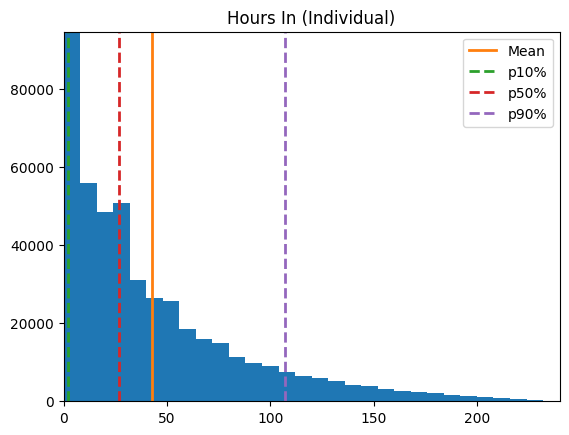

Mean: 42.776187
10% Percentile: 2
50% Percentile: 27
90% Percentile: 107


In [226]:
hours_in = df_notes_ts.index.get_level_values(1).to_numpy()
displayDist(hours_in, 'Hours In (Individual)')

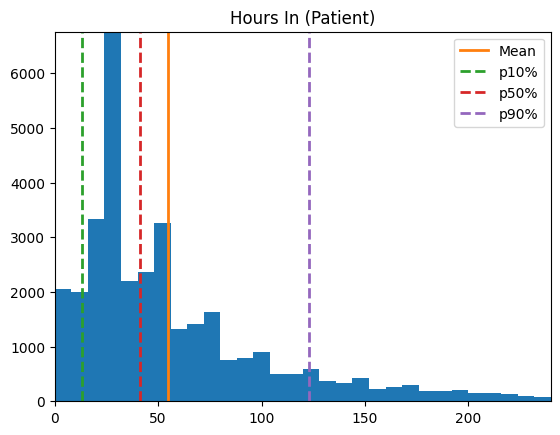

Mean: 54.989253
10% Percentile: 13
50% Percentile: 41
90% Percentile: 123


In [227]:
pat_ids = df_notes_ts.index.get_level_values(0).unique()
pat_len = np.array([max(df_notes_ts.loc[pat_id].index) for pat_id in pat_ids])
displayDist(pat_len, 'Hours In (Patient)', [10,50,90])

### Select first 128 hours for each patient

In [228]:
df_notes_ts = df_notes_ts.loc[df_notes_ts.index.get_level_values(1) < 128]

### Merge notes based on hours in

In [229]:
df_notes_ts = df_notes_ts.groupby(level=[0,1]).agg(' '.join)
df_notes_ts.drop('CATEGORY', axis=1, inplace=True)

### Preprocess text

In [230]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [231]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords)

In [232]:
SUBTEXT_FORMAT = "\[\*\*[^\*]*\*\*\]"
NUMBER_FORMAT = "[0-9]+(,[0-9]+)*(\.[0-9]+)?"
NEWLINE = r"\\"
END_OF_SEQ = "(\\\\n|\.|\?|!|\(|\))+"
PUNCTUATION = "(\\\\|/|-|'|:|#|\"|,|-|_|\+|=|%|<|>|\*|$)"

def prepare_text(s):
    # Remove dates and subtext
    s_pre = re.sub(SUBTEXT_FORMAT, '', s)
    # Remove numbers
    s_pre = re.sub(NUMBER_FORMAT, '', s_pre)
    # Remove newline
    s_pre = re.sub('\n', ' ', s_pre)
    # Remove punctuation
    s_pre = re.sub(PUNCTUATION, ' ', s_pre)
    # Replace escape characters signifying end of a sequence.
    s_pre = re.sub(END_OF_SEQ, ' [SEP] ', s_pre)
    # lowercase text
    s_pre = s_pre.lower()
    # Tokenize message
    s_pre = s_pre.split(' ')
    # Remove stop words
    s_pre = [token for token in s_pre if token not in stopwords and len(token) > 0]
    # Return back to a string
    s_pre = str(s_pre)[1:-1].replace('\'', '').replace(', ', ' ')
    # Remove multiplace consecutive spaces
    s_pre = re.sub('[ ]{2,}', ' ', s_pre)
    # Remove repetitive separations
    s_pre = re.sub(' \[sep\] (\[sep\] )+', ' [sep] ', s_pre)
    # Remove unecessary whitespace
    s_pre = s_pre.strip()
    
    return s_pre

In [233]:
df_notes_static.TEXT = df_notes_static.TEXT.progress_map(lambda t: t if pd.isnull(t) else prepare_text(t))

100%|████████████████████████████████████████████████████████████████████████████| 4312/4312 [00:03<00:00, 1166.26it/s]


In [234]:
df_notes_ts.TEXT = df_notes_ts.TEXT.progress_map(lambda t: t if pd.isnull(t) else prepare_text(t))

100%|████████████████████████████████████████████████████████████████████████| 296437/296437 [01:31<00:00, 3240.76it/s]


In [235]:
txt_len_st = df_notes_static.map(lambda s: len(s)).values.reshape(-1)
txt_len_ts = df_notes_ts.map(lambda s: len(s)).values.reshape(-1)

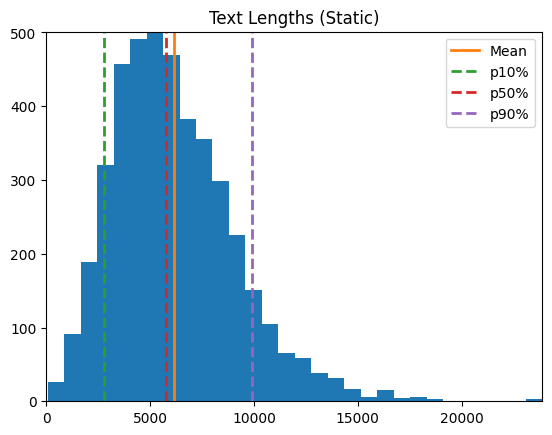

Mean: 6171.408163
10% Percentile: 2771
50% Percentile: 5764
90% Percentile: 9885


In [236]:
displayDist(txt_len_st, 'Text Lengths (Static)', [10,50,90])

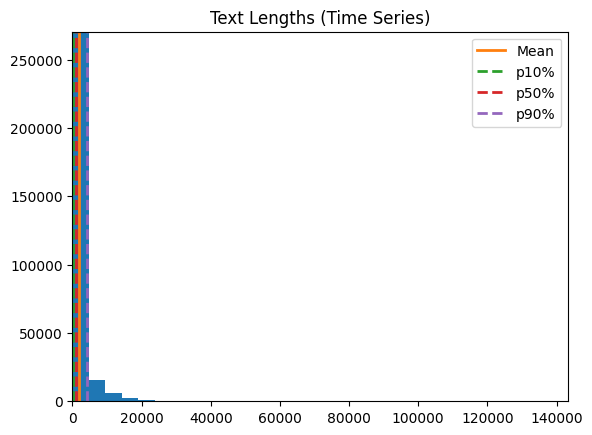

Mean: 1946.358221
10% Percentile: 208
50% Percentile: 950
90% Percentile: 4150


In [237]:
displayDist(txt_len_ts, 'Text Lengths (Time Series)', [10,50,90])

In [238]:
STATIC_WORD_LIMIT = 10000
TS_WORD_LIMIT = 5000

In [239]:
df_notes_static.TEXT = df_notes_static.TEXT.map(lambda s: s[:STATIC_WORD_LIMIT])
df_notes_ts.TEXT = df_notes_ts.TEXT.map(lambda s: s[:TS_WORD_LIMIT])

### Vocab Class

In [240]:
from typing import List
import torch
import os
import json

class Numericize(object):
    def __init__(self):
        self._tok2id = {}
        self._id2tok = {}
        self._tok2cnt = {}
        self._cnt = 1

    def add_token(self, token: str):
        if token not in self._tok2id:
            self._tok2id[token] = self._cnt
            self._id2tok[self._cnt] = token
            self._tok2cnt[token] = 1
            self._cnt += 1
        else:
            self._tok2cnt[token] += 1

    def tok2id(self, token):
        self.add_token(token)
        return self._tok2id[token]

    def numericize(self, data) -> List[int]:
        return [self.tok2id(tok) for tok in data.split(' ')]

    def to_json(self, path: str):
        vocab_data = {
            'tok2id': self._tok2id,
            'id2tok': self._id2tok,
            'tok2cnt': self._tok2cnt,
            'cnt': self._cnt
        }

        with open(path, 'w', encoding='utf-8') as f:
            json.dump(vocab_data, f, indent=4)

    def __len__(self):
        return self._cnt

### Split Notes

In [241]:
processed_dir = '../data/processed/'
train_idxs = set(np.load(os.path.join(processed_dir, 'train_idxs.npy')))
test_idxs = set(np.load(os.path.join(processed_dir, 'test_idxs.npy')))

In [242]:
static_idxs = set(df_notes_static.index.values)
ts_idxs = set(df_notes_ts.index.get_level_values(0).values)

In [243]:
train_idxs_static = list(static_idxs & train_idxs)
test_idxs_static = list(static_idxs & test_idxs)

train_idxs_ts = list(ts_idxs & train_idxs)
test_idxs_ts = list(ts_idxs & test_idxs)

In [244]:
df_static_train = df_notes_static.loc[train_idxs_static].copy()
df_static_test = df_notes_static.loc[test_idxs_static].copy()

In [245]:
df_ts_train = df_notes_ts.loc[train_idxs_ts].copy()
df_ts_test = df_notes_ts.loc[test_idxs_ts].copy()

### Convert to Numbers

In [246]:
numericize = Numericize()

In [247]:
df_static_train_num = df_static_train.TEXT.progress_map(numericize.numericize).tolist()
df_static_test_num = df_static_test.TEXT.progress_map(numericize.numericize).tolist()

100%|██████████████████████████████████████████████████████████████████████████████| 909/909 [00:00<00:00, 5238.71it/s]


In [248]:
df_ts_train_num = df_ts_train.TEXT.progress_map(numericize.numericize).tolist()
df_ts_test_num = df_ts_test.TEXT.progress_map(numericize.numericize).tolist()

100%|█████████████████████████████████████████████████████████████████████████| 58288/58288 [00:03<00:00, 17643.72it/s]


### Save Results

In [249]:
h5_static_filename = 'notes_static.h5'
h5_ts_filename = 'notes_ts.h5'

In [250]:
with h5py.File(os.path.join(processed_dir, 'train/', h5_static_filename), 'w') as train_static_file:
    for row_idx, row in enumerate(df_static_train_num):
        pat_id = train_idxs_static[row_idx]
        train_static_file.create_dataset(f'pat_id_{pat_id}', data=np.array(row))

In [251]:
with h5py.File(os.path.join(processed_dir, 'test/', h5_static_filename), 'w') as test_static_file:
    for row_idx, row in enumerate(df_static_test_num):
        pat_id = test_idxs_static[row_idx]
        test_static_file.create_dataset(f'pat_id_{pat_id}', data=np.array(row))

In [252]:
last_pat_id = -1
pat_group = None
group_idx = 0

with h5py.File(os.path.join(processed_dir, 'train/', h5_ts_filename), 'w') as train_ts_file:
    for (pat_id, note_time), note in zip(df_ts_train.index.tolist(), df_ts_train_num):
        if pat_id != last_pat_id:
            pat_group = train_ts_file.create_group(f'pat_id_{pat_id}')
            group_idx = 0

        pat_group.create_dataset(f'gidx_{group_idx}_time_{note_time}', data=np.array(note))    
        
        last_pat_id = pat_id
        group_idx += 1

In [253]:
last_pat_id = -1
pat_group = None
group_idx = 0

with h5py.File(os.path.join(processed_dir, 'test/', h5_ts_filename), 'w') as test_ts_file:
    for (pat_id, note_time), note in zip(df_ts_test.index.tolist(), df_ts_test_num):
        if pat_id != last_pat_id:
            pat_group = test_ts_file.create_group(f'pat_id_{pat_id}')
            group_idx = 0

        pat_group.create_dataset(f'gidx_{group_idx}_time_{note_time}', data=np.array(note))    
        
        last_pat_id = pat_id
        group_idx += 1

In [254]:
numericize_filepath = os.path.join(processed_dir, 'vocab.json')
numericize.to_json(numericize_filepath)